In [1]:
!pip3 install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "rihabdbouki" # username from the json file
os.environ['KAGGLE_KEY'] = "d4139b267a9bbc766871650fc9b7cf2f" # key from the json file
!kaggle competitions download -c ashrae-energy-prediction

  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 84.9MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 173MB/s]
 91% 109M/120M [00:00<00:00, 76.2MB/s] 
100% 120M/120M [00:01<00:00, 118MB/s] 
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 42.0MB/s]
 83% 73.0M/88.4M [00:00<00:00, 103MB/s] 
100% 88.4M/88.4M [00:00<00:00, 121MB/s]
 92% 153M/167M [00:01<00:00, 88.3MB/s]
100% 167M/167M [00:01<00:00, 111MB/s] 


In [3]:
! unzip /content/weather_test.csv.zip

Archive:  /content/weather_test.csv.zip
  inflating: weather_test.csv        


In [4]:
! unzip /content/sample_submission.csv.zip

Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [5]:
! unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [6]:
! unzip /content/test.csv.zip
! unzip /content/weather_train.csv.zip
! unzip /content/building_metadata.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/weather_train.csv.zip
  inflating: weather_train.csv       
unzip:  cannot find or open /content/building_metadata.csv.zip, /content/building_metadata.csv.zip.zip or /content/building_metadata.csv.zip.ZIP.


# **Imports** 

In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import missingno as msno
import seaborn as sns
import warnings
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [9]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# **Load all data files** 

In [0]:
building = pd.read_csv('./building_metadata.csv')
weather_train = pd.read_csv('./weather_train.csv')
weather_test = pd.read_csv('./weather_test.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# **Data visualization**

###**train**

In [11]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [12]:
from IPython.core.display import display, HTML

nrows = train.shape[0]
nbuildings = train["building_id"].nunique()
max_rows_building = train["building_id"].value_counts().values[0]
min_rows_building = train["building_id"].value_counts().values[-1]
min_date = train["timestamp"].min()
max_date = train["timestamp"].max()
display(HTML(f"""<br>Number of rows in the dataset: {nrows:,}</br>
             <br>Number of buildings in the dataset: {nbuildings:,}</br>
             <br>Maximum of {max_rows_building:,} rows is available for a building</br>
             <br>Minimum of {min_rows_building:,} rows is available for a building</br>
             <br>Min date value in train data is {min_date}</br>
             <br>Max date value in train data is {max_date}</br>
             """))

In [13]:
train.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype=object)

In [14]:
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
cnt_srs = train["meter"].value_counts()
cnt_srs = cnt_srs.sort_index()
cnt_srs.index = ["Electricity", "ChilledWater", "Steam", "HotWater"]
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="#1E90FF",
    ),
)

layout = go.Layout(
    title=go.layout.Title(
        text="Number of rows for each meter type",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="meter")

#####**some feature stats**

In [15]:
train.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


###**weather_train**

In [16]:
print('Size of weather_train_df data', weather_train.shape)

Size of weather_train_df data (139773, 9)


In [17]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [18]:
weather_train.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

###**weather_test**

In [19]:
print('Size of weather_test_df data', weather_test.shape)

Size of weather_test_df data (277243, 9)


In [20]:
weather_test.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [21]:
weather_test.columns.values

array(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'], dtype=object)

###**building_meta**

In [22]:
print('Size of building_meta_df data', building.shape)

Size of building_meta_df data (1449, 6)


In [23]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [24]:
building.columns.values

array(['site_id', 'building_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count'], dtype=object)

#**Data preparation**

###**Merging everything into two datasets: train and test**

In [0]:
train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')
del weather_train, weather_test,building
gc.collect();

###**Saving some memory**


In [0]:
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

###**Datetime Features**

In [0]:
train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekend"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

In [28]:
train[["hour", "day", "weekend", "month"]]

,hour,day,weekend,month
0,0,1,4,1
1,0,1,4,1
2,0,1,4,1
3,0,1,4,1
4,0,1,4,1
...,...,...,...,...
20216095,23,31,5,12
20216096,23,31,5,12
20216097,23,31,5,12
20216098,23,31,5,12


###**remove redundant columns**

In [0]:
train = train.drop("timestamp", axis = 1)

In [30]:
train.head(7)

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month
0,0,0,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,4,1
1,1,0,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,4,1
2,2,0,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,4,1
3,3,0,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,4,1
4,4,0,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,4,1
5,5,0,0.0,0,Education,8000,2000.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,4,1
6,6,0,0.0,0,Lodging/residential,27926,1981.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0,0,1,4,1


#**feature engineering**

###**Label encoding for "primary_use"**

In [0]:
le = LabelEncoder()
train["primary_use"] = le.fit_transform(train["primary_use"])

###**Examine and deal with Missing Values**

In [32]:
# checking missing data
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(14)

,Total,Percent
floor_count,16709167,82.652772
year_built,12127645,59.990033
cloud_coverage,8825365,43.655131
precip_depth_1_hr,3749023,18.544739
wind_direction,1449048,7.167792
sea_level_pressure,1231669,6.092515
wind_speed,143676,0.710701
dew_temperature,100140,0.495348
air_temperature,96658,0.478124
primary_use,0,0.000000


**The msno.matrix nullity matrix is a data-dense display which lets you quickly visually analyse data completion.**

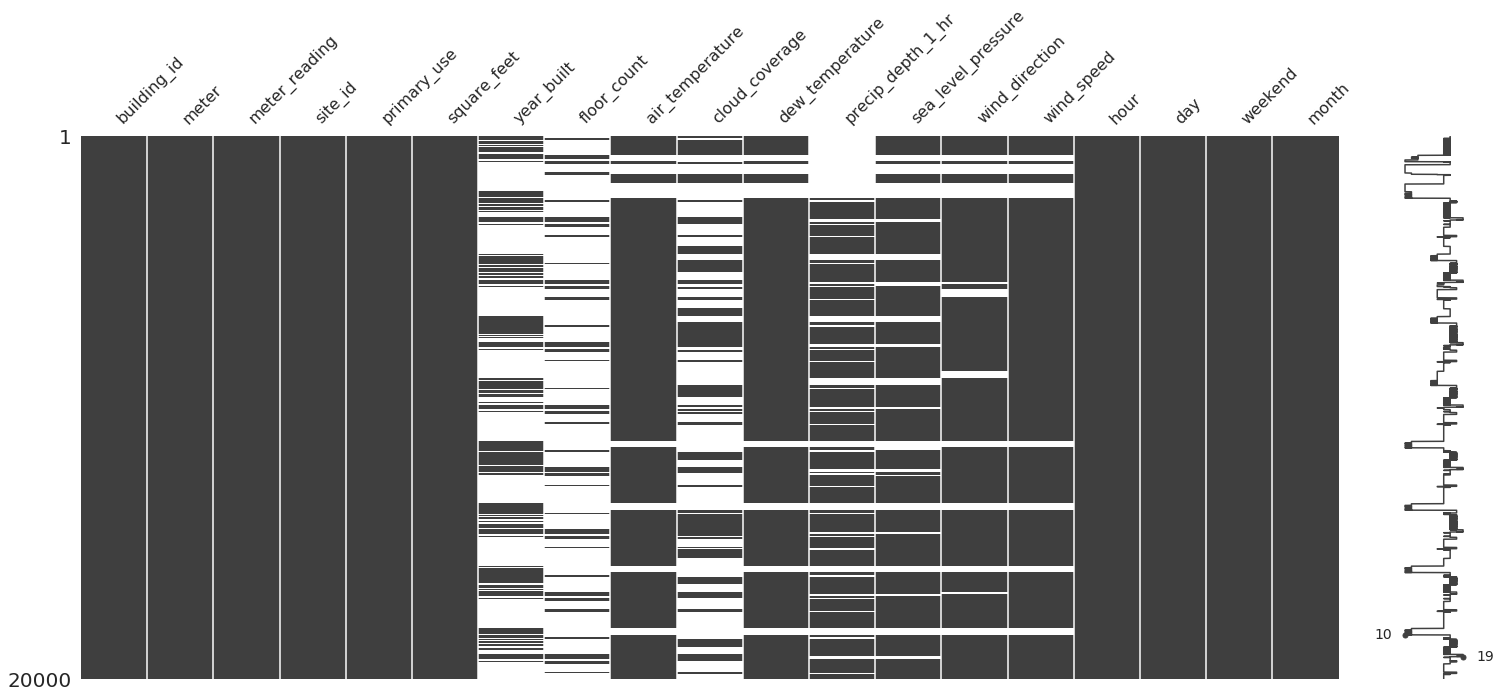

In [33]:
msno.matrix(train.head(20000))

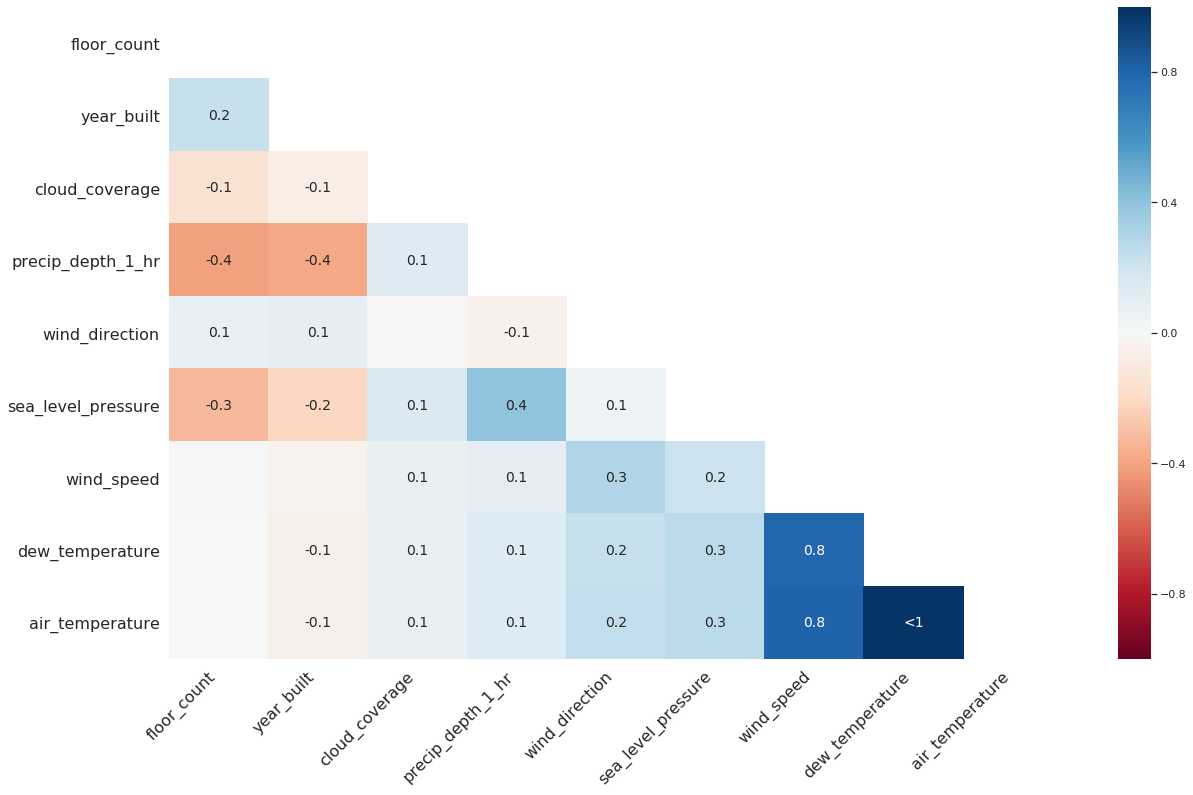

In [34]:
a = msno.heatmap(train, sort='ascending')

###**we can refill missing values with mean or median**

In [0]:
del train['floor_count']
del train['year_built']
del train['cloud_coverage']

In [0]:
train['air_temperature'].fillna(train['air_temperature'].mean(), inplace=True)
train['dew_temperature'].fillna(train['dew_temperature'].mean(), inplace=True)
train['sea_level_pressure'].fillna(train['sea_level_pressure'].mean(), inplace=True)

In [0]:
train['wind_speed'].fillna(train['wind_speed'].median(), inplace=True)
train['precip_depth_1_hr'].fillna(train['precip_depth_1_hr'].median(), inplace=True)

In [0]:
train['wind_direction'].fillna(train['wind_direction'].median(), inplace=True)

In [39]:
train.isnull().sum()

building_id           0
meter                 0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
day                   0
weekend               0
month                 0
dtype: int64

#####**There are 4 types of meters: 0 = electricity, 1 = chilledwater, 2 = steam, 3 = hotwater. We use the one hot encoding for this 4 feature.**

In [0]:
train= pd.get_dummies(train, columns=['meter'])

In [41]:
train.head()

,building_id,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month,meter_0,meter_1,meter_2,meter_3
0,0,0.0,0,0,7432,25.0,20.0,0.0,1019.700012,0.0,0.0,0,1,4,1,1,0,0,0
1,1,0.0,0,0,2720,25.0,20.0,0.0,1019.700012,0.0,0.0,0,1,4,1,1,0,0,0
2,2,0.0,0,0,5376,25.0,20.0,0.0,1019.700012,0.0,0.0,0,1,4,1,1,0,0,0
3,3,0.0,0,0,23685,25.0,20.0,0.0,1019.700012,0.0,0.0,0,1,4,1,1,0,0,0
4,4,0.0,0,0,116607,25.0,20.0,0.0,1019.700012,0.0,0.0,0,1,4,1,1,0,0,0


####**Feature engineering of numeric attributes:Outliers**

In [0]:
numeric_vars_part_1 = ['square_feet','air_temperature','precip_depth_1_hr']
numeric_vars_part_2=['sea_level_pressure','wind_direction','wind_speed']
my_df_numeric_1 = train[numeric_vars_part_1].copy()
my_df_numeric_2 = train[numeric_vars_part_2].copy()

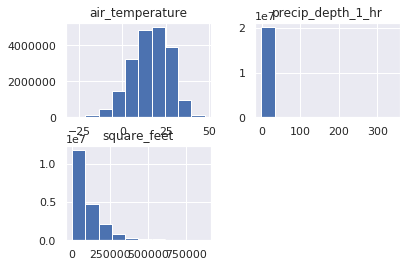

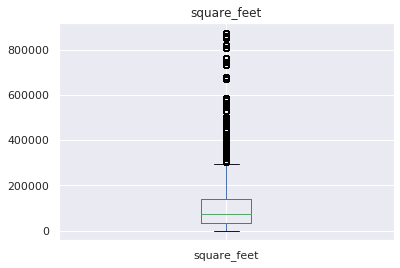

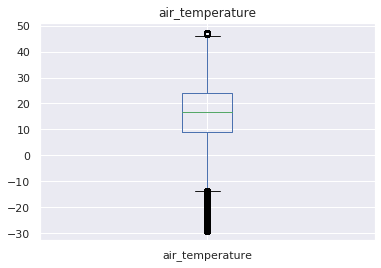

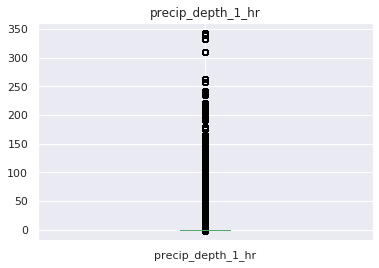

In [43]:
fig1=my_df_numeric_1.hist()
plt.show()

for x in my_df_numeric_1:
    my_df_numeric_1[x].plot.box()
    plt.title(x)
    plt.show()

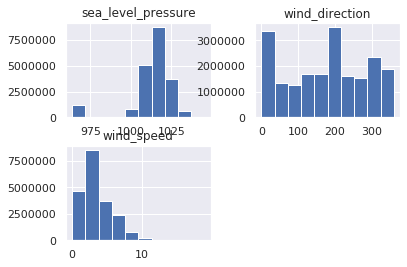

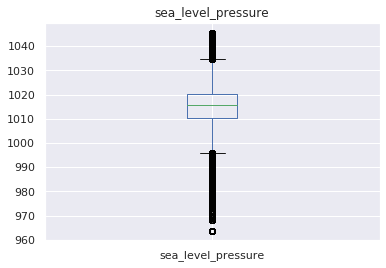

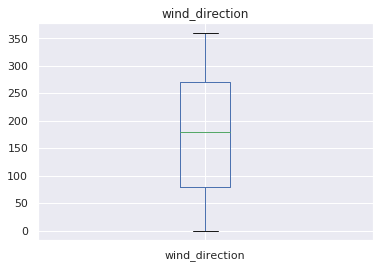

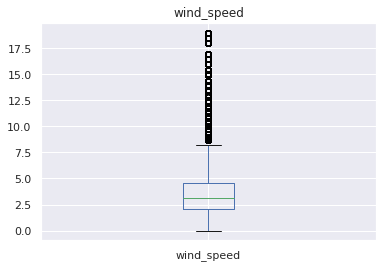

In [44]:
fig1=my_df_numeric_2.hist()
plt.show()

for x in my_df_numeric_2:
    my_df_numeric_2[x].plot.box()
    plt.title(x)
    plt.show()

###**Scaling very skewed features**

In [0]:
train_scale=['square_feet','air_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
mean = train[train_scale].mean(axis=0)
train[train_scale] = train[train_scale].astype('float32')
train[train_scale] -= train[train_scale].mean(axis=0)
std = train[train_scale].std(axis=0)
train[train_scale] /= train[train_scale].std(axis=0)

In [46]:
train.head()

,building_id,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month,meter_0,meter_1,meter_2,meter_3
0,0,0.0,0,0,-0.849577,0.859435,20.0,-0.096782,6.609203,0.0,-1.640538,0,1,4,1,1,0,0,0
1,1,0.0,0,0,-0.890899,0.859435,20.0,-0.096782,6.609203,0.0,-1.640538,0,1,4,1,1,0,0,0
2,2,0.0,0,0,-0.867608,0.859435,20.0,-0.096782,6.609203,0.0,-1.640538,0,1,4,1,1,0,0,0
3,3,0.0,0,0,-0.707047,0.859435,20.0,-0.096782,6.609203,0.0,-1.640538,0,1,4,1,1,0,0,0
4,4,0.0,0,0,0.107834,0.859435,20.0,-0.096782,6.609203,0.0,-1.640538,0,1,4,1,1,0,0,0


###**Target Variable Analysis - meter_reading**

In [0]:
'''Function to distribution plot'''
def distplot(variable, color):
    global ax
    font_size = 16
    title_size = 20
    plt.rcParams['figure.figsize'] = (18, 10)
    ax = sns.distplot(variable, color = color)
    plt.xlabel('%s' %variable.name, fontsize = font_size)
    plt.ylabel('Count ', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.title(' Distribution of '+'%s' %variable.name, fontsize = title_size)
    plt.show()

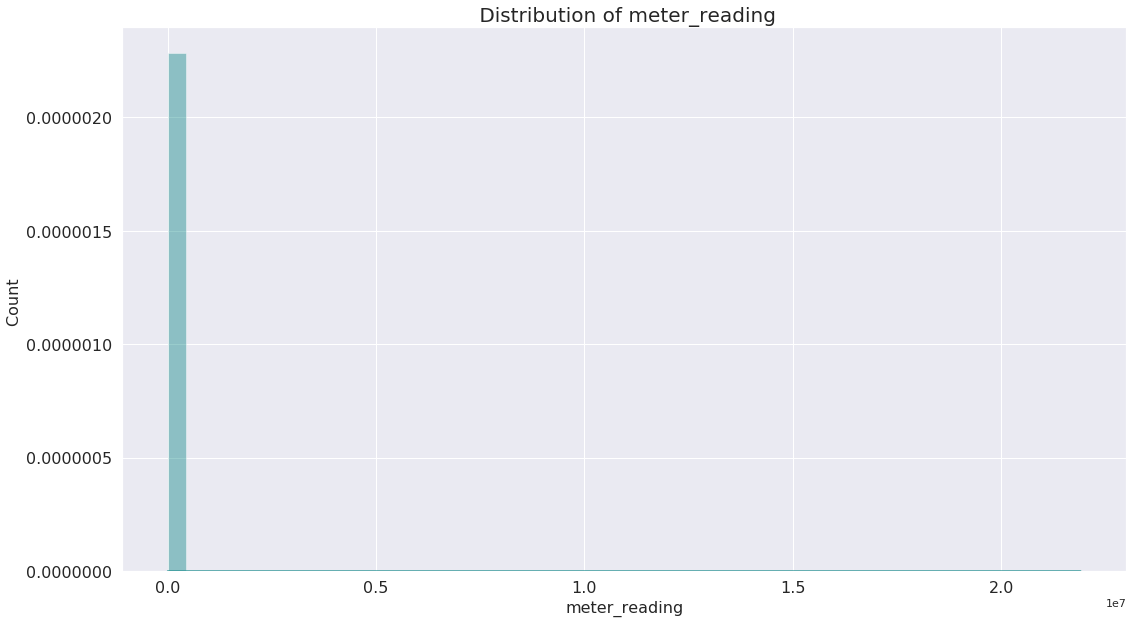

In [48]:
'''Distribution of the Meter Reading'''
distplot(train['meter_reading'], 'teal')

In [49]:
'''Summary of meter reading'''
train['meter_reading'].describe()

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [0]:
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

**Distribution after log tranformation**

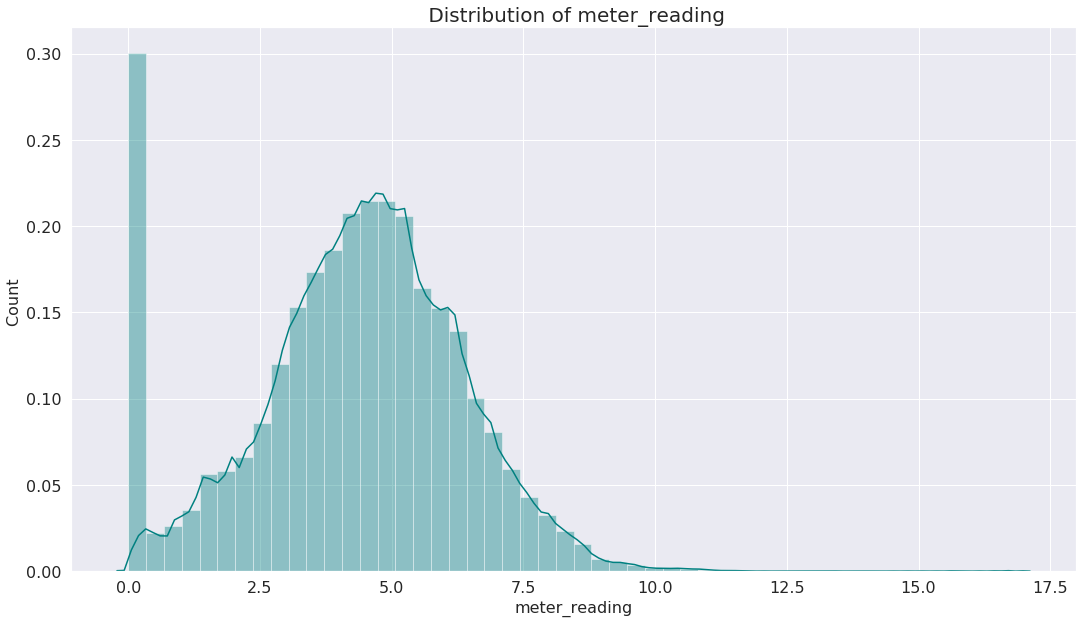

In [51]:
'''Log tranformation of meter_reading'''
train['meter_reading'] = np.log1p(train['meter_reading'])
bold('**Distribution after log tranformation**')
distplot(train['meter_reading'], 'teal')

###**Correlation between meter_reading And Numeric Variable**

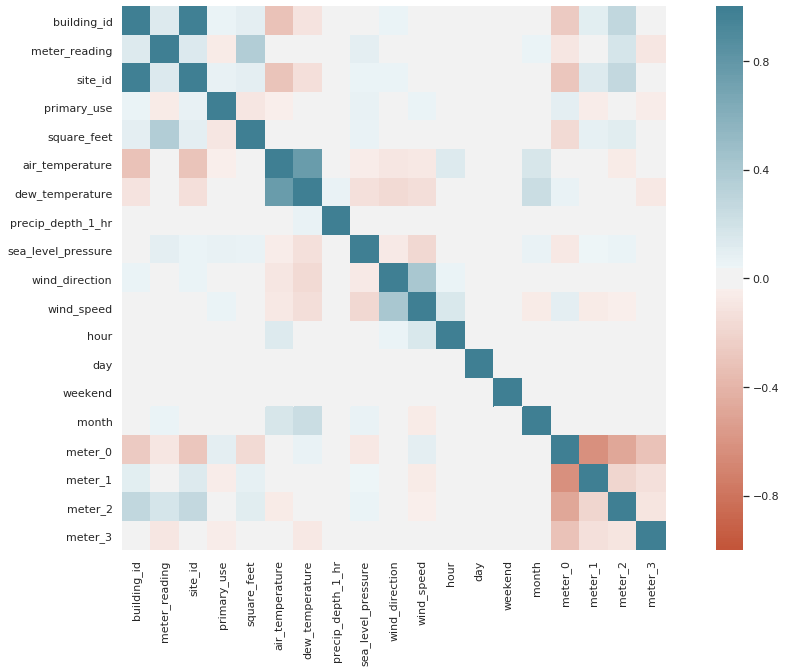

In [52]:
plt.rcParams['figure.figsize'] = (18,10)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

#**Split the input data into train and validation**

###**Define the features**

In [0]:
Y=train[['meter_reading']]
X=train.drop(columns=['meter_reading'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [55]:
print(X_test.shape, X_train.shape, y_test.shape, y_train.shape)

(5054025, 18) (15162075, 18) (5054025, 1) (15162075, 1)


#**Create LSTM neural network** 

####**LSTM model requires 3 dimensions input for that we have to reshape the input** 

In [0]:
X = X_train.to_numpy()
X=X.reshape(15162075,1,18)

In [0]:
X_val = X_test.to_numpy()
X_val=X_val.reshape(5054025,1,18)

In [0]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))

In [58]:
dropout=0.2
lr=0.001
model = Sequential()
model.add(LSTM(512,activation='relu',input_shape=(1, 18),return_sequences=True))
model.add(LSTM(256,activation='relu',return_sequences=True))
model.add(LSTM(128,activation='relu',return_sequences=True))
model.add(LSTM(64,activation='relu' ,return_sequences=True))
model.add(Dropout(dropout), )
model.add(LSTM(1,activation='relu' ,return_sequences=False))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
opt = Adam(lr)
model.compile(loss='mse',optimizer =opt,metrics=[root_mean_squared_error])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 512)            1087488   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            787456    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1)                 264       
Total params: 2,121,736
Trainable params: 2,121,736
Non-trainable params: 0
______________________________________________

In [0]:
#early stopping
earlyStopping = EarlyStopping(monitor='val_loss',patience = 5, verbose=1)
hist = model.fit(X, y_train, epochs=32, batch_size=8192,validation_data=(X_val,y_test),callbacks= [earlyStopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 15162075 samples, validate on 5054025 samples
Epoch 1/32
15162075/15162075 [==============================] - 2333s 154us/sample - loss: 2.9178 - root_mean_squared_error: 1.6904 - val_loss: 2.3153 - val_root_mean_squared_error: 1.5215
Epoch 2/32
15162075/15162075 [==============================] - 2296s 151us/sample - loss: 2.1781 - root_mean_squared_error: 1.4753 - val_loss: 1.9230 - val_root_mean_squared_error: 1.3866
Epoch 3/32
15162075/15162075 [==============================] - 2346s 155us/sample - loss: 1.9498 - root_mean_squared_error: 1.3959 - val_loss: 1.7245 - val_root_mean_squared_error: 1.3131
Epoch 4/32
15162075/15162075 [==============================] - 2302s 152us/sample - loss: 1.7852 - root_mean_squared_error: 1.3357 - val_loss: 1.6725 - val_root_mean_squared_error: 1.2931
Epoch 5/32
15162075/15162075 [==============================] - 2298s 152us/sample - loss: 1.67